## Imports
We load NumPy for array math, pandas for tables, Matplotlib for production charts, SciPy's stats module for reliability quantiles, and CVXPY for solving the convex production planning problem.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp
from typing import Dict, Any, Tuple

### Line-by-Line: Imports (Cell 2)
1. `import numpy as np` – Numerical foundation for array operations (production cost calculations, random parameter generation).
2. `import pandas as pd` – Tabular summaries of machine parameters and production results for reporting.
3. `import matplotlib.pyplot as plt` – Visualizes production allocations and cost vs buffer trade-offs.
4. `import scipy.stats as stats` – Provides quantile (`ppf`) used to convert reliability into a safety production buffer under a Normal assumption.
5. `import cvxpy as cp` – Optimization modeling: declare decision variables (production per machine), objective, constraints, and solve the quadratic program.
6. `from typing import Dict, Any, Tuple` – Type hints for clarity when returning structured result dictionaries.

Manufacturing Formulation:
We minimize total production cost subject to meeting a reliability-adjusted customer demand level and respecting each production machine's capacity limits.

## Production System Class
This class randomly generates a fleet of convex production machines. Parameters: `n_machines` controls fleet size, `seed` ensures reproducibility, coefficient bounds define quadratic and linear production cost parameters, and `capacity_bounds` set min/max output units. Methods `describe()` and `total_capacity()` summarize the factory.

In [37]:
class ProductionSystem:
    """
    Factory model holding production machine cost curves and capacity limits.

    Each machine i has cost: C_i(x_i) = alpha_i x_i^2 + beta_i x_i + gamma_i
    with 0 <= x_i <= u_i (minimum assumed zero).
    """
    def __init__(self, n_machines: int = 5, seed: int = 42,
                 alpha_bounds: Tuple[float, float] = (0.05, 0.2),
                 beta_bounds: Tuple[float, float] = (2.0, 5.0),
                 gamma_bounds: Tuple[float, float] = (10.0, 20.0),
                 capacity_bounds: Tuple[float, float] = (50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        # Quadratic production cost curvature
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        # Linear production cost slope
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        # Fixed cost component
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        # Lower/upper production capacity (units)
        self.l = np.zeros(n_machines)
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)

    def describe(self) -> pd.DataFrame:
        machines = np.arange(1, self.n + 1)
        data = {
            "alpha": self.alpha,
            "beta": self.beta,
            "gamma": self.gamma,
            "min_cap": self.l,
            "max_capacity": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("production_machine")

    def total_capacity(self) -> float:
        return float(np.sum(self.u))

### Line-by-Line: ProductionSystem Class (Cell 4)
1. `class ProductionSystem:` – Defines factory container for production machines.
2. Docstring – States economic cost model per machine with quadratic + linear + fixed terms.
3. Constructor parameters map manufacturing context: counts, reproducible seed, cost coefficient bounds, and capacity ranges (units).
4. Local RNG ensures reproducibility without disturbing global NumPy state.
5. `self.n` stores number of production machines.
6–8. `alpha`, `beta`, `gamma` sampled: curvature, linear variable production cost, fixed overhead.
9–10. `self.l` lower bound (zero), `self.u` sampled upper production capacity per machine (units).
11. `describe()` builds a DataFrame summarizing parameters with manufacturing-centric index name `production_machine`.
12. Columns include `alpha`, `beta`, `gamma`, `min_cap`, `max_capacity` (renamed from power terminology).
13. `total_capacity()` returns aggregate feasible production units: sum of all `max_capacity`.
14. These parameters feed the optimization: choose each machine's production level to meet customer demand at minimum cost.

Manufacturing View:
We allocate production across machines with different efficiency curves, ensuring total output satisfies a reliability-adjusted customer demand requirement while respecting machine capacities.

## Production Planning Solver
`solve_dispatch` enforces a reliability-adjusted customer demand. Inputs: `system` (factory), `mu_D`/`sigma_D` (demand stats), `reliability` (service level), and `mode` (Normal vs Chebyshev). It builds CVXPY variable `x` (production units), computes effective demand `D_eff`, sets up quadratic production cost objective, enforces capacity + demand constraints, solves, and returns primal/dual economic signals.

In [38]:
def solve_dispatch(
    system: ProductionSystem,
    mu_D: float,
    sigma_D: float,
    reliability: float = 0.95,
    mode: str = "normal",
) -> Dict[str, Any]:
    """Solve the stochastic production planning problem under Normal or Chebyshev reliability buffering.

    We convert a probabilistic customer demand requirement into a deterministic
    effective demand D_eff then solve:
        minimize   sum_i (alpha_i x_i^2 + beta_i x_i)
        subject to sum_i x_i >= D_eff
                   0 <= x_i <= max_capacity_i
    Fixed costs gamma_i are added after solving for reporting.

    Returns dictionary with optimal production vector, total cost (incl. gamma),
    effective demand enforced, and dual multipliers:
      lambda : shadow price of 1 additional unit of required demand
      nu_u   : scarcity indicator per machine at its capacity
      nu_l   : lower bound duals (typically zero here)
    """
    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie strictly between 0 and 1")

    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability

    if mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'normal' or 'robust'")

    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective customer demand exceeds installed production capacity")

    objective = cp.Minimize(
        cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x))
    )

    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status}

    dispatch = x.value
    total_cost = float(
        np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma)
    )

    return {
        "status": prob.status,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

### Line-by-Line: solve_dispatch Function (Cell 6)
(Manufacturing interpretation retained; mathematical logic unchanged.)
1. Function signature & parameters reframe the problem as production planning.
2. Input validation ensures realistic non-negative demand stats and proper reliability probability.
3. Decision variable x[i] = units produced by machine i.
4. Reliability complement alpha_risk used in Chebyshev buffer formula.
5. Normal mode: z-score converts reliability to safety units: D_eff = mu + z*sigma.
6. Robust mode: distribution-free Chebyshev buffer: D_eff = mu + sqrt((1-α)/α)*sigma.
7. Capacity feasibility check prevents futile solve attempts if demand buffer impossible.
8. Objective uses only variable portions (alpha x^2 + beta x) since fixed gamma doesn’t affect argmin.
9. Constraints enforce meeting effective customer demand and staying within machine capacities.
10. Problem solved with OSQP (quadratic program).
11. If optimal, collect production vector, add back fixed gamma for full cost accounting.
12. Return dictionary of primal solution plus dual multipliers (economic signals).
13. `lambda` (system marginal production cost) higher when near capacity or buffer large.
14. `nu_u` identifies machines where expanding capacity would lower total cost.
15. `nu_l` usually zero (no minimum forced production).
Trade-off: Higher reliability or robust distributional assumption inflates D_eff, raising cost.

## KKT Verification
`verify_kkt` checks manufacturing optimality: stationarity (balanced marginal production costs & dual signals) and complementary slackness on the customer demand constraint.

In [39]:
def verify_kkt(system: ProductionSystem, res: Dict[str, Any], tol: float = 1e-4) -> Dict[str, float]:
    """Compute stationarity and complementary slackness residuals."""
    
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution unavailable.")
        return {}
    
    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]
    
    grad_f = 2 * system.alpha * dispatch + system.beta
    stationarity_residual = grad_f - lam + nu_u - nu_l
    max_stationarity = float(np.max(np.abs(stationarity_residual)))
    
    total_prod = float(np.sum(dispatch))
    slack = total_prod - res["D_eff"]
    comp_slack_error = float(abs(slack * lam))
    
    print("\n--- KKT CHECK ---")
    print(f"Stationarity residual: {max_stationarity:.2e}")
    print(f"Complementary slackness residual: {comp_slack_error:.2e}")
    
    if max_stationarity < tol and comp_slack_error < tol:
        print("KKT conditions satisfied within tolerance.")
    else:
        print("Warning: residuals exceed tolerance.")
    
    return {"stationarity": max_stationarity, "slackness": comp_slack_error}

### Line-by-Line: verify_kkt Function (Cell 8)
1. Guard: skips test unless solution optimal.
2. Extract production vector and dual multipliers.
3. Compute gradient of variable production cost per machine.
4. Stationarity residual: (grad_f - lambda + nu_upper - nu_lower) should be ~0 for all machines.
5. Complementary slackness: (Σ production - D_eff)*lambda ≈ 0 (either buffer tight or shadow price near zero).
6. Print residuals for diagnostic clarity; compare against tolerance.
7. Return residuals for further automated checks.
Economic Interpretation:
- lambda: marginal cost of one more required customer demand unit.
- nu_upper[i]: value of relaxing machine i’s capacity by 1 unit if it is binding.
Manufacturing Insight: Machines with positive nu_upper are bottlenecks; capacity expansion or load shifting there could reduce total cost.

## Production Summary Table
`summarize_dispatch` merges machine parameters with solution outputs: production units, slacks to bounds, dual multipliers, marginal production cost, and each machine's total production cost share.

In [40]:
def summarize_dispatch(system, res):
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    production = res["x"]
    table = system.describe().copy()
    table["production"] = production
    table["upper_slack"] = system.u - production
    table["lower_slack"] = production - system.l
    table["nu_upper"] = res["nu_u"]
    table["nu_lower"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * production + system.beta
    table["incremental_cost"] = system.alpha * production**2 + system.beta * production + system.gamma
    return table

### Line-by-Line: summarize_dispatch Function (Cell 10)
1. Feasibility guard ensures only valid solutions summarized.
2. Extract optimal machine production vector.
3. Start from static machine parameter table (cost coefficients & capacities).
4. Add `production` column: actual units produced per machine.
5. Add `upper_slack`: available headroom before capacity limit (units).
6. Add `lower_slack`: distance above minimum production (here equals production as min is zero).
7. Add duals `nu_upper` / `nu_lower` for binding status insight.
8. Compute `marginal_cost`: derivative of production cost curve at chosen production level.
9. Compute `incremental_cost`: total cost contribution per machine (including fixed).
10. Return enriched manufacturing-oriented table for reporting.
Use Cases: Identify bottleneck machines (low upper_slack & positive nu_upper) and high marginal cost units for potential efficiency improvements.

In [41]:
# 1. Create the factory
my_factory = ProductionSystem(n_machines=5)

# 2. Define the customer demand scenario
MEAN_DEMAND = 300
SIGMA = 30
RELIABILITY = 0.95  # 95% service level

# 3. Run the Normal (Gaussian) buffering model
print("--- NORMAL MODEL (Gaussian demand) ---")
res_normal = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="normal"
)
print(f"Total Production Cost: ${res_normal['cost']:,.2f}")
print(f"Effective required production (D_eff): {res_normal['D_eff']:.2f} units")

# 4. Run the Robust (Chebyshev) buffering model
print("\n--- ROBUST MODEL (Distribution-free) ---")
res_robust = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="robust"
)
print(f"Total Production Cost: ${res_robust['cost']:,.2f}")
print(f"Effective required production (D_eff): {res_robust['D_eff']:.2f} units")

# 5. Verify optimality (Normal model)
verify_kkt(my_factory, res_normal)

--- NORMAL MODEL (Gaussian demand) ---
Total Production Cost: $4,305.68
Effective required production (D_eff): 349.35 units

--- ROBUST MODEL (Distribution-free) ---
Total Production Cost: $6,336.46
Effective required production (D_eff): 430.77 units

--- KKT CHECK ---
Stationarity residual: 3.52e-13
Complementary slackness residual: 1.23e-12
KKT conditions satisfied within tolerance.


{'stationarity': 3.5216274341109965e-13, 'slackness': 1.2315451736330222e-12}

### Line-by-Line: 5-Machine Scenario Demo (Cell 11)
1. Instantiate a 5-machine factory with randomized cost curves and capacities.
2. Define customer demand statistics (mean units and variability).
3. Choose a 95% service level (probability production meets realized demand).
4. Normal model: assumes demand is approximately Gaussian → z‑score buffer.
5. Print total production cost including fixed overheads and the effective required production units D_eff.
6. Robust model: assumes only mean & variance known (Chebyshev) → larger safety buffer.
7. Print cost and D_eff again for comparison (expect higher values).
8. Run KKT verification to confirm optimality conditions for the normal solution.
Manufacturing Insight: Robust buffering trades additional production (inventory / readiness) for higher reliability under distributional ambiguity.

## Scenario Comparison
We instantiate a 6-machine factory, set customer demand statistics (`mu_D`, `sigma_D`) and service level, then solve under both Gaussian (`normal`) and Chebyshev (`robust`) assumptions. For each mode we store results, show effective required production, total production cost, a preview of the production table, and run KKT checks.

In [42]:
# Scenario comparison for Gaussian vs. Chebyshev buffering
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0
sigma_D = 40.0
reliability = 0.95

print("Production machine parameters (cost coefficients & capacities):")
print(system.describe())

results = {}
summaries = {}
for mode in ("normal", "robust"):
    print(f"\n=== {mode.title()} model ===")
    res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
    results[mode] = res
    summary = summarize_dispatch(system, res)
    summaries[mode] = summary
    print(f"Effective required production: {res['D_eff']:.1f} units")
    print(f"Total production cost: ${res['cost']:.2f}")
    print(summary[["production", "max_capacity", "marginal_cost"]])
    verify_kkt(system, res)

Production machine parameters (cost coefficients & capacities):
                       alpha      beta      gamma  min_cap  max_capacity
production_machine                                                      
1                   0.143764  2.015796  12.548696      0.0    112.217923
2                   0.184582  4.463685  14.450763      0.0    148.896015
3                   0.166353  4.391208  15.045483      0.0     71.530870
4                   0.083781  3.403805  15.534974      0.0     66.021203
5                   0.095025  2.909097  19.955003      0.0    111.253960
6                   0.181033  2.835277  17.926619      0.0     54.394201

=== Normal model ===
Effective required production: 415.8 units
Total production cost: $5359.32
                    production  max_capacity  marginal_cost
production_machine                                         
1                    75.517454    112.217923      23.729227
2                    52.186926    148.896015      23.729227
3              

### Line-by-Line: Scenario Comparison Loop (Cell 13)
1. Create 6-machine factory for richer heterogeneity.
2. Define mean customer demand and variability (standard deviation).
3. Set common service level (reliability) for fair mode comparison.
4. Print machine parameter table (costs & capacities).
5. Initialize dictionaries to store raw results and summarized production tables.
6. Loop over two reliability modeling approaches: Gaussian (Normal) and distribution-free (Robust).
7. Solve production planning under each mode; store results.
8. Build summary DataFrame with production, slacks, marginal costs, duals.
9. Report effective required production units D_eff (risk-buffered level).
10. Report total production cost including fixed overhead.
11. Display selected columns: production, max_capacity, marginal_cost.
12. Run KKT verification to confirm optimal solution properties.
Manufacturing Interpretation: Robust mode typically increases buffer production, elevating costs but improving resilience to demand shape uncertainty.

## Visualization
We compare production levels between reliability modes via grouped bars and overlay dashed lines at each machine’s production capacity (`system.u`).

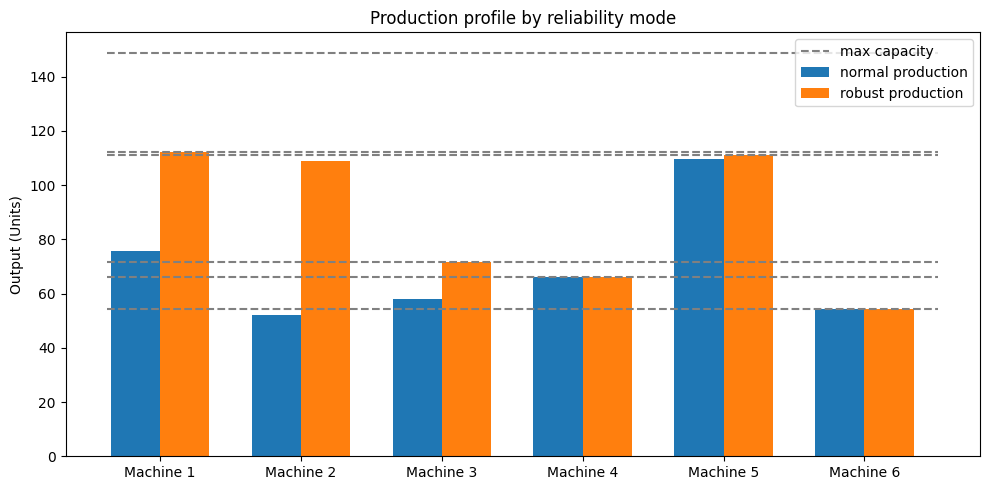

In [43]:
# Visual comparison of production decisions
modes = list(summaries.keys())
indices = np.arange(system.n)
width = 0.35

plt.figure(figsize=(10, 5))
for i, mode in enumerate(modes):
    plt.bar(indices + i * width, summaries[mode]["production"], width, label=f"{mode} production")

plt.hlines(system.u, xmin=-0.2, xmax=indices[-1] + len(modes) * width, colors="gray", linestyles="dashed", label="max capacity")
plt.xticks(indices + width / 2, [f"Machine {i+1}" for i in indices])
plt.ylabel("Output (Units)")
plt.title("Production profile by reliability mode")
plt.legend()
plt.tight_layout()
plt.show()

## Simplified Visual Summary
We keep only the two most informative manufacturing views:

1. Production Bar Chart: Shows how each machine contributes under each reliability model (Normal vs Robust) relative to its capacity.
2. Cost & Buffer Comparison: Summarizes how total production cost rises when we hold a larger safety buffer (robust case).

Removed plots (marginal cost curves, demand distribution shading, supply sweeps, dashboards) were detailed but not essential here.

Interpretation Tips:
- Colored bars: actual machine production; dashed gray line: machine capacity. Bar touching the line = machine saturated.
- Robust mode typically increases effective required production (D_eff), pushing more machines near capacity and raising cost.
- Buffer difference (Robust − Normal) = extra preventive production to satisfy service level without assuming a specific demand shape.

Below a concise printed summary translates numbers into plain language.

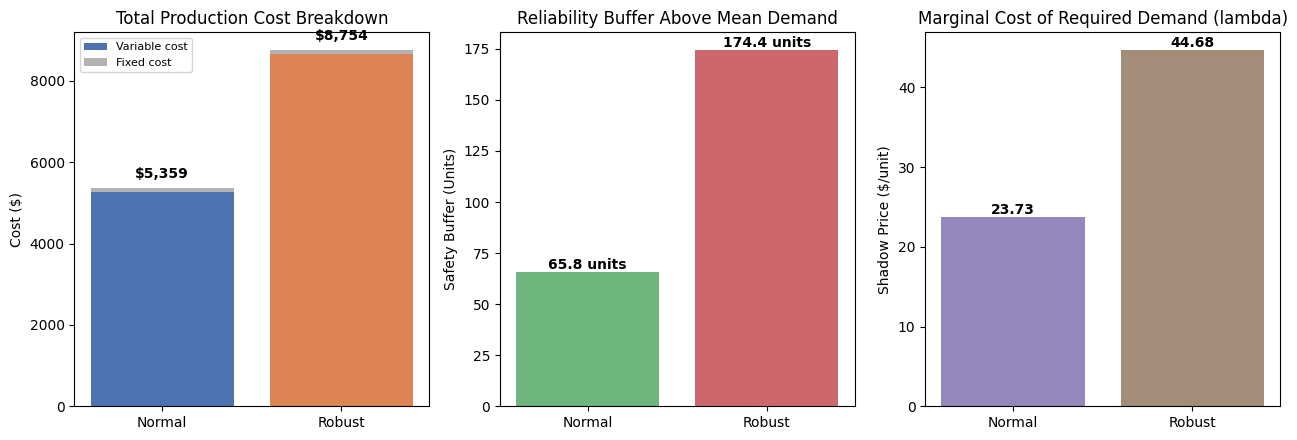

Plain English Summary:
Robust planning holds about 108.6 extra safety units (buffer beyond mean) versus Normal.
Variable production cost increases by $3,394; total cost rises by $3,394 (≈ 63.3%).
Shadow price λ shifts from 23.73 to 44.68, indicating higher marginal cost pressure under the larger buffer.
Interpretation: The robust (distribution-free) assumption inflates the required production level, driving higher variable spend while fixed overhead remains unchanged.


In [46]:
# Enhanced cost & reliability comparison with economic breakdown
normal = results["normal"]
robust = results["robust"]

# Extract production vectors (used for variable cost breakdown if needed)
prod_normal = normal["x"]
prod_robust = robust["x"]

# Separate variable vs fixed cost components
fixed_cost = float(np.sum(system.gamma))  # same for both modes
var_cost_normal = float(np.sum(system.alpha * prod_normal**2 + system.beta * prod_normal))
var_cost_robust = float(np.sum(system.alpha * prod_robust**2 + system.beta * prod_robust))

total_normal = var_cost_normal + fixed_cost
total_robust = var_cost_robust + fixed_cost

# Effective demand buffers (safety units above mean)
buffers = [normal["D_eff"] - mu_D, robust["D_eff"] - mu_D]
labels = ["Normal", "Robust"]

# Shadow price (lambda) comparison: marginal cost of one more required unit
lambda_vals = [normal["lambda"], robust["lambda"]]

# Differences
extra_buffer = buffers[1] - buffers[0]
extra_var_cost = var_cost_robust - var_cost_normal
extra_total_cost = total_robust - total_normal
pct_increase_total = (extra_total_cost / total_normal) * 100 if total_normal > 0 else np.nan

plt.figure(figsize=(13, 4.5))

# Subplot 1: Cost breakdown stacked (variable vs fixed)
plt.subplot(1, 3, 1)
plt.bar(labels, [var_cost_normal, var_cost_robust], color=["#4C72B0", "#DD8452"], label="Variable cost")
plt.bar(labels, [fixed_cost, fixed_cost], bottom=[var_cost_normal, var_cost_robust], color="#808080", alpha=0.6, label="Fixed cost")
for i, (vc, tc) in enumerate(zip([var_cost_normal, var_cost_robust], [total_normal, total_robust])):
    plt.text(i, tc + max(total_normal, total_robust) * 0.02, f"${tc:,.0f}", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Cost ($)")
plt.title("Total Production Cost Breakdown")
plt.legend(fontsize=8)

# Subplot 2: Reliability buffer units
plt.subplot(1, 3, 2)
plt.bar(labels, buffers, color=["#55A868", "#C44E52"], alpha=0.85)
for i, b in enumerate(buffers):
    plt.text(i, b, f"{b:.1f} units", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Safety Buffer (Units)")
plt.title("Reliability Buffer Above Mean Demand")
plt.axhline(0, color="black", linewidth=0.5)

# Subplot 3: Shadow price (lambda)
plt.subplot(1, 3, 3)
plt.bar(labels, lambda_vals, color=["#8172B3", "#937860"], alpha=0.85)
for i, lam in enumerate(lambda_vals):
    plt.text(i, lam, f"{lam:.2f}", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Shadow Price ($/unit)")
plt.title("Marginal Cost of Required Demand (lambda)")

plt.tight_layout()
plt.show()

# Plain language summary
print("Plain English Summary:")
print(f"Robust planning holds about {extra_buffer:.1f} extra safety units (buffer beyond mean) versus Normal.")
print(f"Variable production cost increases by ${extra_var_cost:,.0f}; total cost rises by ${extra_total_cost:,.0f} (≈ {pct_increase_total:.1f}%).")
print(f"Shadow price λ shifts from {lambda_vals[0]:.2f} to {lambda_vals[1]:.2f}, indicating higher marginal cost pressure under the larger buffer.")
print("Interpretation: The robust (distribution-free) assumption inflates the required production level, driving higher variable spend while fixed overhead remains unchanged.")

### Explanation: Enhanced Comparison (Cell 25)
This revised cell clarifies three economic dimensions:
1. Cost Breakdown: Separates variable production cost (depends on allocation) from fixed overhead (gamma), making clear the robust mode only raises the variable portion.
2. Reliability Buffer: Shows extra preventive production units above mean demand; robust mode uses a distribution-free inequality leading to a larger buffer.
3. Shadow Price (lambda): Economic marginal cost of tightening the demand constraint; higher under robust buffering due to approaching capacity limits.
Key Insights:
- Fixed cost is identical across modes; the difference stems from higher variable utilization.
- Extra buffer (Robust − Normal) quantifies the precautionary production commitment.
- Rising lambda signals scarcity: each additional required unit is more expensive when buffers grow.
Use this tri-panel view to communicate trade-offs between resilience (buffer), operational efficiency (variable cost), and marginal economics (shadow price).

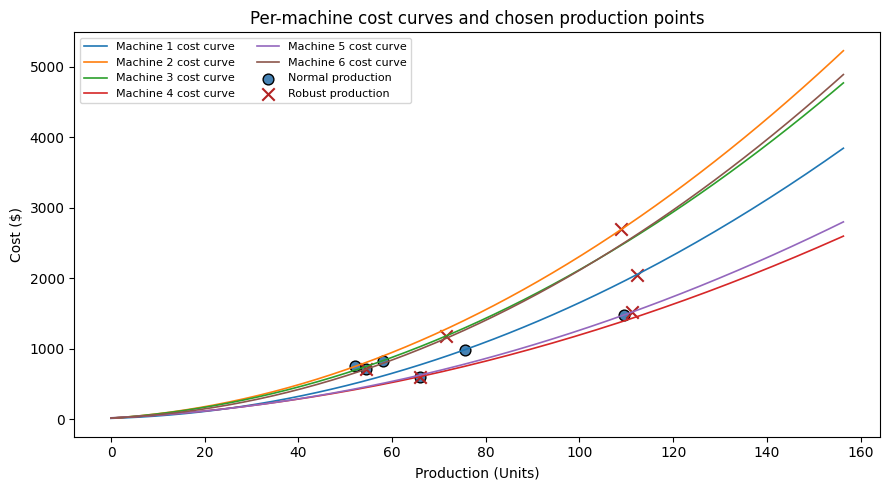

In [45]:
# Per-machine cost curves with chosen production points (Normal vs Robust)
import numpy as np
import matplotlib.pyplot as plt

# Ensure prerequisite objects exist: `system`, `results`
if 'system' not in globals() or 'results' not in globals():
    raise RuntimeError("Factory system or results dictionary is not defined. Run the scenario comparison cells first.")
if 'normal' not in results or 'robust' not in results:
    raise RuntimeError("Expected 'normal' and 'robust' keys in results. Run the comparison loop cell.")

x_plot = np.linspace(0, system.u.max() * 1.05, 200)
plt.figure(figsize=(9, 5))
for i in range(system.n):
    alpha_i = system.alpha[i]
    beta_i = system.beta[i]
    gamma_i = system.gamma[i]
    cost_curve = alpha_i * x_plot**2 + beta_i * x_plot + gamma_i
    plt.plot(x_plot, cost_curve, label=f"Machine {i+1} cost curve", linewidth=1.2)

# Production points for each reliability modeling mode
prod_normal = results['normal']['x']
prod_robust = results['robust']['x']
cost_normal = system.alpha * prod_normal**2 + system.beta * prod_normal + system.gamma
cost_robust = system.alpha * prod_robust**2 + system.beta * prod_robust + system.gamma

plt.scatter(prod_normal, cost_normal, marker='o', color='steelblue', edgecolor='black', s=60, label='Normal production')
plt.scatter(prod_robust, cost_robust, marker='x', color='firebrick', s=80, label='Robust production')

plt.title("Per-machine cost curves and chosen production points")
plt.xlabel("Production (Units)")
plt.ylabel("Cost ($)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

## Demand vs Total Cost Sweep
We vary the mean customer demand (while holding demand volatility and reliability constant) and solve the production planning problem under both buffering assumptions:
- Normal (Gaussian) buffer uses z-score * sigma.
- Robust (distribution-free Cantelli/Chebyshev) buffer uses sqrt(reliability/(1-reliability)) * sigma.
For feasibility at every point we restrict the demand range so that *both* modes remain solvable (effective demand does not exceed total installed capacity). The plot highlights how precautionary buffering amplifies variable production cost growth as demand rises.

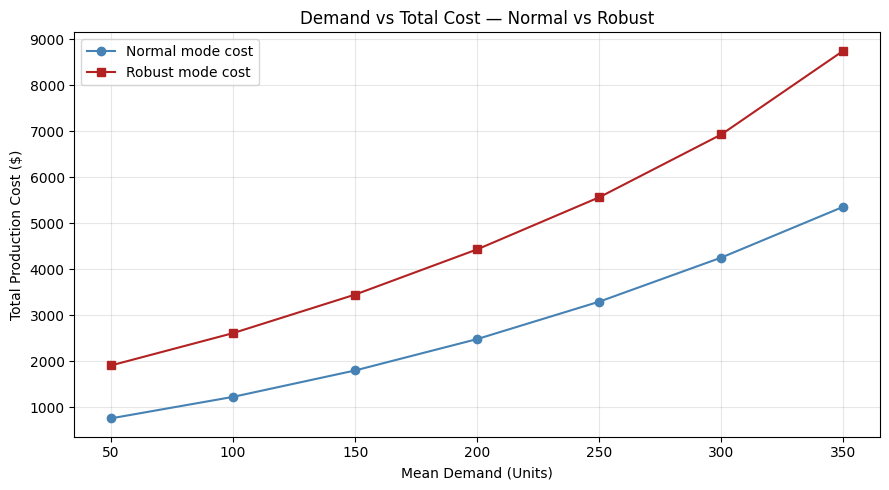

Sweep summary (first few rows):
   mean_demand  normal_cost  robust_cost  normal_D_eff  robust_D_eff
0         50.0   755.769390  1906.882330    115.794145    224.355958
1        100.0  1222.785287  2609.648043    165.794145    274.355958
2        150.0  1797.634014  3448.319936    215.794145    324.355958
3        200.0  2480.598824  4432.204745    265.794145    374.355958
4        250.0  3294.405001  5565.324280    315.794145    424.355958


In [47]:
# Demand vs Total Cost plot (Normal vs Robust)
import numpy as np
import matplotlib.pyplot as plt

# Preconditions
if 'system' not in globals():
    raise RuntimeError("'system' not found. Run the scenario comparison cell to create the ProductionSystem instance.")
if 'sigma_D' not in globals() or 'reliability' not in globals():
    raise RuntimeError("Expected 'sigma_D' and 'reliability' variables from earlier cells.")

sigma = sigma_D  # demand standard deviation (held constant)
rel = reliability

# Safety factors
z_score = stats.norm.ppf(rel)
k_robust = np.sqrt(rel / (1 - rel))  # Cantelli one-sided bound factor

# Maximum feasible mean demand for both modes (keep both solvable)
cap = system.total_capacity()
max_mu_normal = cap - z_score * sigma
max_mu_robust = cap - k_robust * sigma
max_mu = min(max_mu_normal, max_mu_robust)

# Choose a start demand (>=0) and build range in steps of 50 units
step = 50
start_mu = max(0, step) if max_mu >= step else 0
# Ensure at least one point
if start_mu > max_mu:
    raise ValueError("No feasible demand range given current buffer parameters and capacity.")

mu_values = np.arange(start_mu, max_mu + 1e-9, step)

normal_costs = []
robust_costs = []
normal_eff_demands = []
robust_eff_demands = []

for mu in mu_values:
    res_n = solve_dispatch(system, mu, sigma, reliability=rel, mode='normal')
    res_r = solve_dispatch(system, mu, sigma, reliability=rel, mode='robust')
    normal_costs.append(res_n['cost'])
    robust_costs.append(res_r['cost'])
    normal_eff_demands.append(res_n['D_eff'])
    robust_eff_demands.append(res_r['D_eff'])

plt.figure(figsize=(9,5))
plt.plot(mu_values, normal_costs, marker='o', label='Normal mode cost', color='steelblue')
plt.plot(mu_values, robust_costs, marker='s', label='Robust mode cost', color='firebrick')
plt.xlabel('Mean Demand (Units)')
plt.ylabel('Total Production Cost ($)')
plt.title('Demand vs Total Cost — Normal vs Robust')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show a small summary table
import pandas as pd
summary_df = pd.DataFrame({
    'mean_demand': mu_values,
    'normal_cost': normal_costs,
    'robust_cost': robust_costs,
    'normal_D_eff': normal_eff_demands,
    'robust_D_eff': robust_eff_demands,
})
print("Sweep summary (first few rows):")
print(summary_df.head())